
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.95      0.51      0.66      2145

    accuracy                           1.00    555719
   macro avg       0.97      0.76      0.83    555719
weighted avg       1.00      1.00      1.00    555719


ROC AUC Score: 0.9704374434060076


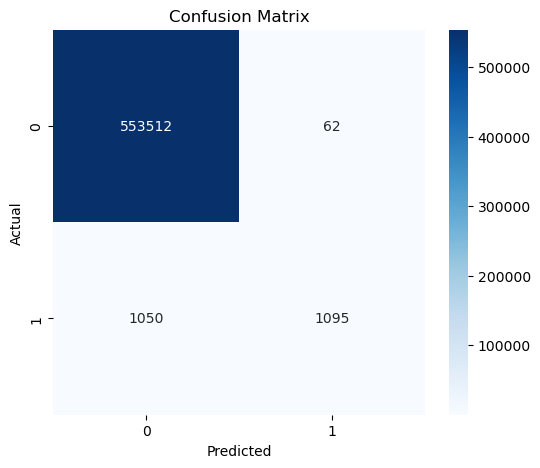

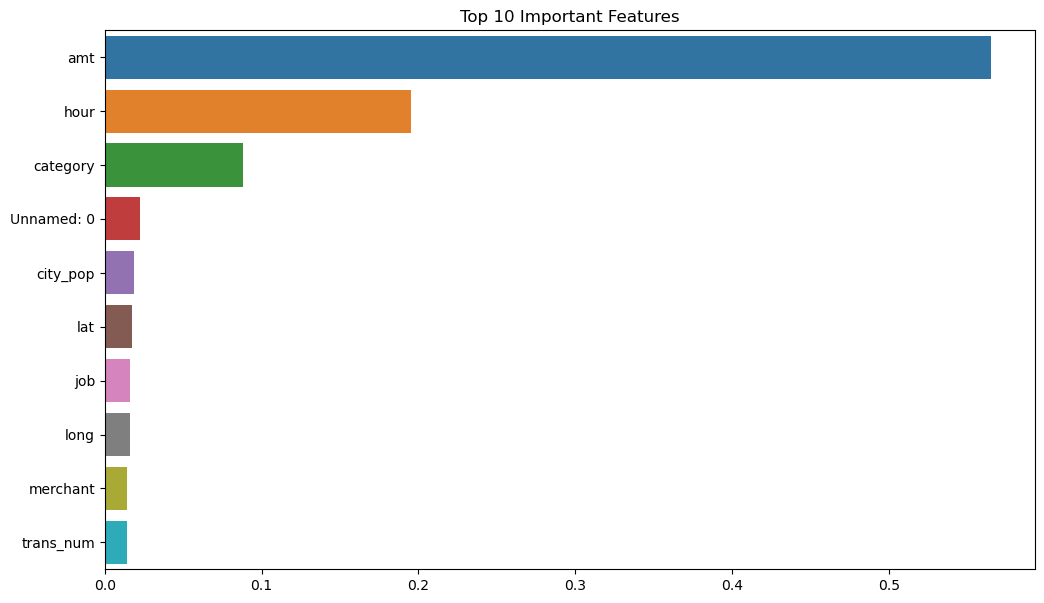


Number of False Positives: 62
Number of False Negatives: 1050

Sample False Positives:
       Unnamed: 0  merchant  category      amt  gender      lat     long  \
21704       21704       201        12  1029.49       0  40.0246 -79.6955   
45961       45961       480        12   715.67       1  32.8357 -79.8217   
51720       51720       302         8   665.43       1  31.2462 -83.6549   
54247       54247       594        11  1049.89       0  40.1151 -79.8627   
58626       58626       193        11   906.21       1  42.2470 -73.7552   

       city_pop  job  trans_num  hour  day_of_week  day  month  
21704      2303  327     451846    22            6   28      6  
45961     20478  274     337891    22            0    6      7  
51720      5666  390     242527    22            2    8      7  
54247       427  286     461827     2            4   10      7  
58626     17867  466     486536    22            5   11      7  

Sample False Negatives:
      Unnamed: 0  merchant  category    

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight

# ---------------------------
# 1. Data Preprocessing
# ---------------------------

def preprocess(df):
    df = df.copy()

    # Parse datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month

    # Drop unnecessary columns
    df = df.drop([
        'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 
        'city', 'state', 'zip', 'dob', 'unix_time', 'merch_lat', 'merch_long'
    ], axis=1)

    # Encode all object type columns
    object_cols = df.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in object_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    return df

# ---------------------------
# 2. Model Building
# ---------------------------

def build_model(X_train, y_train):
    # Handle class imbalance
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), weights))

    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    model.fit(X_train, y_train)

    return model

# ---------------------------
# 3. Model Evaluation
# ---------------------------

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Feature importance
    importances = model.feature_importances_
    feature_names = X_test.columns
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12,7))
    sns.barplot(x=importances[indices][:10], y=feature_names[indices][:10])
    plt.title('Top 10 Important Features')
    plt.show()

# ---------------------------
# 4. Explain Misclassifications
# ---------------------------

def explain_errors(model, X_test, y_test):
    y_pred = model.predict(X_test)

    false_positives = X_test[(y_test == 0) & (y_pred == 1)]
    false_negatives = X_test[(y_test == 1) & (y_pred == 0)]

    print(f"\nNumber of False Positives: {len(false_positives)}")
    print(f"Number of False Negatives: {len(false_negatives)}")

    print("\nSample False Positives:")
    print(false_positives.head())

    print("\nSample False Negatives:")
    print(false_negatives.head())

# ---------------------------
# 5. Main Execution
# ---------------------------

def main():
    # Load the data
    train_df = pd.read_csv('/Users/tanishakumar/Desktop/growthlink/fraudTrain.csv')
    test_df = pd.read_csv('/Users/tanishakumar/Desktop/growthlink/fraudTest.csv')

    # Preprocess
    train_df = preprocess(train_df)
    test_df = preprocess(test_df)

    # Separate features and labels
    X_train = train_df.drop('is_fraud', axis=1)
    y_train = train_df['is_fraud']
    X_test = test_df.drop('is_fraud', axis=1)
    y_test = test_df['is_fraud']

    # Train model
    model = build_model(X_train, y_train)

    # Evaluate model
    evaluate_model(model, X_test, y_test)

    # Explain errors
    explain_errors(model, X_test, y_test)

if __name__ == "__main__":
    main()
